In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#to confirm gpu access
import tensorflow as tf
device_name=tf.test.gpu_device_name()
print(device_name)

Mounted at /content/drive
/device:GPU:0


In [ ]:
!pip install tqdm
!pip install torch
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
# import transformers
# from datasets import Dataset,load_dataset, load_from_disk
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import mean_squared_error
# from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch
import math

In [ ]:
os.chdir('/content/drive/MyDrive/nlp_project')

In [ ]:
def RemoveWords(data , feature) :
    for i in range(data.shape[0]) :
        this_phrase = data[feature][i]
        new_phrase = []
        for word in this_phrase.split() :
            new_phrase.append(word.lower())
        data.loc[i, feature] = ' '.join(new_phrase)

In [ ]:
all=pd.read_csv('all_data.csv')
annotator_data=pd.read_csv('toxicity_individual_annotations.csv')

In [ ]:
columns = ['id', 'comment_text', 'toxicity_annotator_count', 'toxicity']
drop_cols = []
for c in all.columns:
  if c not in columns:
    drop_cols.append(c)
all = all.drop(drop_cols, axis=1)
ambiguous = all[all['toxicity_annotator_count'] > 70]
unambiguous = all[all['toxicity_annotator_count'] <= 70]

In [ ]:
ambiguous_len = len(ambiguous)
ambiguous_0 = ambiguous[:int(ambiguous_len/2)]
ambiguous_1 = ambiguous[int(ambiguous_len/2)+1:]

In [ ]:
train_test = pd.concat([ambiguous_1,unambiguous[:135000]])
train_test.to_csv('train_test.csv')

In [ ]:
threshold = 10
c = 1
analysis_10 = pd.DataFrame()
for i in ambiguous_0['id']:
  noisy_toxicity_value=(annotator_data[annotator_data['id']==i][:threshold]['toxic'].sum())/threshold
  analysis_10=analysis_10.append({'id':int(i),'toxicity':noisy_toxicity_value},ignore_index=True)
  print(str(c)+' done')
  c+=1
analysis_10.to_csv('analysis_10.csv', encoding='utf-8')

In [ ]:
threshold = 10
c = 1
analysis_10 = pd.DataFrame()
for i in ambiguous_0['id']:
  noisy_toxicity_value=(annotator_data[annotator_data['id']==i][:threshold]['toxic'].sum())/threshold
  analysis_10=analysis_10.append({'id':int(i),'toxicity':noisy_toxicity_value},ignore_index=True)
  print(str(c)+' done')
  c+=1
analysis_10.to_csv('analysis_10.csv', encoding='utf-8')

In [ ]:
threshold = 30
c = 1
analysis_30 = pd.DataFrame()
for i in ambiguous_0['id']:
  noisy_toxicity_value=(annotator_data[annotator_data['id']==i][:threshold]['toxic'].sum())/threshold
  analysis_30=analysis_30.append({'id':int(i),'toxicity':noisy_toxicity_value},ignore_index=True)
  print(str(c)+' done')
  c+=1
analysis_30.to_csv('analysis_30.csv', encoding='utf-8')

In [ ]:
threshold = 50
c = 1
analysis_50 = pd.DataFrame()
for i in ambiguous_0['id']:
  noisy_toxicity_value=(annotator_data[annotator_data['id']==i][:threshold]['toxic'].sum())/threshold
  analysis_50=analysis_50.append({'id':int(i),'toxicity':noisy_toxicity_value},ignore_index=True)
  print(str(c)+' done')
  c+=1
analysis_50.to_csv('analysis_50.csv', encoding='utf-8')

In [ ]:
threshold = 70
c = 1
analysis_70 = pd.DataFrame()
for i in ambiguous_0['id']:
  noisy_toxicity_value=(annotator_data[annotator_data['id']==i][:threshold]['toxic'].sum())/threshold
  analysis_70=analysis_70.append({'id':int(i),'toxicity':noisy_toxicity_value},ignore_index=True)
  print(str(c)+' done')
  c+=1
analysis_70.to_csv('analysis_70.csv', encoding='utf-8')

In [ ]:
train_test = pd.read_csv('train_test.csv')
train_test = train_test.drop(['id','Unnamed: 0','toxicity_annotator_count'],axis=1)
train_test.rename(columns={'comment_text':'text', 'toxicity':'label'}, inplace = True)

In [ ]:
RemoveWords(train_test, 'text')

In [ ]:
dataset = Dataset.from_pandas(train_test,preserve_index=False)
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 134741
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 14972
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/135 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)
model.resize_token_embeddings(len(tokenizer))
from datasets import load_metric
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  num_train_epochs=2,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end=False,
                                  # label_names = ['toxicity']
                                  )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 134741
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8422
  Number of trainable parameters = 66954241


Epoch,Training Loss,Validation Loss,Rmse
1,0.016500,0.013471,0.116065
2,0.008900,0.011549,0.107467


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 14972
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 14972
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=8422, training_loss=0.012702058653060344, metrics={'train_runtime': 12844.6964, 'train_samples_per_second': 20.98, 'train_steps_per_second': 0.656, 'total_flos': 3.5696942908962816e+16, 'train_loss': 0.012702058653060344, 'epoch': 2.0})

In [ ]:
tokenized_datasets["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 134741
})

In [ ]:
os.chdir('/content/drive/MyDrive/nlp_model')

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
def pipeline_prediction(text):
    df=pd.DataFrame({'text':[text]})
    dataset = Dataset.from_pandas(df,preserve_index=False)
    tokenized_datasets = dataset.map(tokenize_function)
    raw_pred, _, _ = trainer.predict(tokenized_datasets)
    return(raw_pred[0][0])


In [ ]:
!ls

model  tokenizer


In [ ]:
# # save the model/tokenizer
# model.save_pretrained("model")
# tokenizer.save_pretrained("tokenizer")
# load the model/tokenizer
from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
unambiguous

,id,comment_text,toxicity,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,0.373134,67
2,5902188,And Trump continues his lifelong cowardice by ...,0.666667,63
5,6290444,"Cry me a river, why don't you.\nDrinking, drug...",0.203390,59
7,5730298,That is Child Abuse!!!,0.192982,57
8,5167187,That's right. They are not normal. And I am st...,0.803279,61
...,...,...,...,...
1999511,1018736,Another man shamming article. If white men did...,0.400000,10
1999512,340016,"""no matter what is put in front of you regardi...",0.400000,10
1999513,919629,The Democrat party aided and abetted by it's M...,0.400000,10
1999514,5165492,I just don't find her a very good representati...,0.400000,10


In [ ]:
for x in [5,2,1999515]:
  print(unambiguous['comment_text'][x])
  print(unambiguous['toxicity'][x])
  print(pipeline_prediction(unambiguous['comment_text'][x]))
  print("________________________________________________________________________________________")

Cry me a river, why don't you.
Drinking, drugs, dressing like a ho.  Bad recipe for disaster!
0.2033898305084745


  0%|          | 0/1 [00:00<?, ?ex/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


0.06908468
________________________________________________________________________________________
And Trump continues his lifelong cowardice by not making this announcement himself.

What an awful human being .....
0.6666666666666666


  0%|          | 0/1 [00:00<?, ?ex/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


0.65947247
________________________________________________________________________________________
You know the Trump fanatics are trolling the G&M ........ when you see Trudeau being called a Muslim
0.4


  0%|          | 0/1 [00:00<?, ?ex/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


0.6330572
________________________________________________________________________________________


In [ ]:
import random

In [ ]:
pipeline_prediction(unambiguous['comment_text'][0])

  0%|          | 0/1 [00:00<?, ?ex/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1
  Batch size = 8


0.59604096

In [ ]:
torch.save(model.state_dict(), '/model2')


In [ ]:
os.chdir('/content/drive/MyDrive/nlp_project')

In [ ]:
analysis_10 = pd.read_csv('analysis_10.csv')
analysis_30 = pd.read_csv('analysis_30.csv')
analysis_50 = pd.read_csv('analysis_50.csv')
analysis_70 = pd.read_csv('analysis_70.csv')
analysis_90 = pd.read_csv('analysis_90.csv')
analysis_110 = pd.read_csv('analysis_110.csv')
analysis_130 = pd.read_csv('analysis_130.csv')
analysis_150 = pd.read_csv('analysis_150.csv')

In [ ]:
ldf = [analysis_10, analysis_30, analysis_50, analysis_70, analysis_90, analysis_110, analysis_130, analysis_150]
def clean(ldf):
  for i in range(len(ldf)):
    ldf[i] = ldf[i].drop(['Unnamed: 0'],axis=1)
  return ldf
ldf = clean(ldf)

In [ ]:
ambiguous_0['srno'] = range(len(ambiguous_0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
ambiguous_0.set_index('srno', inplace=True)

In [ ]:
analysis = pd.DataFrame()
analysis['id'] = ldf[0]['id']
analysis['ann_10'] = ldf[0]['toxicity']
analysis['ann_30'] = ldf[1]['toxicity']
analysis['ann_50'] = ldf[2]['toxicity']
analysis['ann_70'] = ldf[3]['toxicity']
analysis['ann_90'] = ldf[4]['toxicity']
analysis['ann_110'] = ldf[5]['toxicity']
analysis['ann_130'] = ldf[6]['toxicity']
analysis['ann_150'] = ldf[7]['toxicity']
analysis.to_csv('analysis.csv')
analysis['sum'] = analysis['ann_10']+analysis['ann_30']+analysis['ann_50']+analysis['ann_70']+analysis['ann_90']+analysis['ann_110']+analysis['ann_130']+analysis['ann_150']
analysis
# delete all rows with column 'Age' has value 30 to 40
condition = analysis[(analysis['sum'] == 0)].index
analysis.drop(condition , inplace=True)
analysis['srno'] = range(len(analysis['id']))
analysis.set_index('srno',inplace=True)

In [ ]:
analysis.to_csv('analysis.csv')

In [ ]:
analysis = pd.read_csv('analysis.csv')

In [ ]:
analysis

,srno,id,ann_10,ann_30,ann_50,ann_70,ann_90,ann_110,ann_130,ann_150,sum
0,0,650904.0,0.4,0.533333,0.60,0.600000,0.605263,0.605263,0.605263,0.605263,4.554386
1,1,5410943.0,0.6,0.533333,0.52,0.542857,0.550000,0.550000,0.550000,0.550000,4.396190
2,2,5764010.0,0.3,0.533333,0.50,0.514286,0.525000,0.525000,0.525000,0.525000,3.947619
3,3,5263240.0,0.9,0.866667,0.78,0.700000,0.710526,0.710526,0.710526,0.710526,6.088772
4,4,320268.0,0.8,0.700000,0.72,0.728571,0.736111,0.736111,0.736111,0.736111,5.893016
...,...,...,...,...,...,...,...,...,...,...,...
13201,13201,303884.0,0.8,0.800000,0.74,0.714286,0.737500,0.737500,0.737500,0.737500,6.004286
13202,13202,725286.0,0.4,0.633333,0.66,0.714286,0.722222,0.722222,0.722222,0.722222,5.296508
13203,13203,5668076.0,0.9,0.966667,0.94,0.914286,0.912500,0.912500,0.912500,0.912500,7.370952
13204,13204,4962998.0,0.4,0.466667,0.42,0.457143,0.447368,0.447368,0.447368,0.447368,3.533283


In [ ]:
col  =[]
id=analysis["id"]
for i in tqdm(id[:100]):
  col.append(pipeline_prediction(list(all[all["id"]==i]['comment_text'])[0]))
analysis_top_100=analysis[:100]
analysis_top_100["predicted"] = col

In [ ]:
Y = []
ids = analysis['id']
for i in ids:
  Y.append(float(ambiguous_0[ambiguous_0['id']==i]['toxicity']))

In [ ]:
analysis_top_100['original'] = Y[:100]
analysis_top_100.to_csv('analysis_top_100.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
analysis_top_100 = pd.read_csv('analysis_top_100.csv')

In [ ]:
analysis_top_100

,srno,id,ann_10,ann_30,ann_50,ann_70,ann_90,ann_110,ann_130,ann_150,sum,predicted,original
0,0,650904.0,0.4,0.533333,0.60,0.600000,0.605263,0.605263,0.605263,0.605263,4.554386,0.622246,0.605263
1,1,5410943.0,0.6,0.533333,0.52,0.542857,0.550000,0.550000,0.550000,0.550000,4.396190,0.832540,0.550000
2,2,5764010.0,0.3,0.533333,0.50,0.514286,0.525000,0.525000,0.525000,0.525000,3.947619,0.489984,0.525000
3,3,5263240.0,0.9,0.866667,0.78,0.700000,0.710526,0.710526,0.710526,0.710526,6.088772,0.710096,0.710526
4,4,320268.0,0.8,0.700000,0.72,0.728571,0.736111,0.736111,0.736111,0.736111,5.893016,0.714089,0.736111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,5281381.0,0.6,0.600000,0.68,0.657143,0.661972,0.661972,0.661972,0.661972,5.185030,0.656779,0.661972
96,96,5820597.0,0.5,0.566667,0.60,0.642857,0.631579,0.631579,0.631579,0.631579,4.835840,0.712505,0.631579
97,97,5643313.0,0.4,0.533333,0.56,0.585714,0.613333,0.613333,0.613333,0.613333,4.532381,0.574118,0.613333
98,98,5869816.0,0.7,0.766667,0.78,0.742857,0.728395,0.728395,0.728395,0.728395,5.903104,0.758554,0.728395


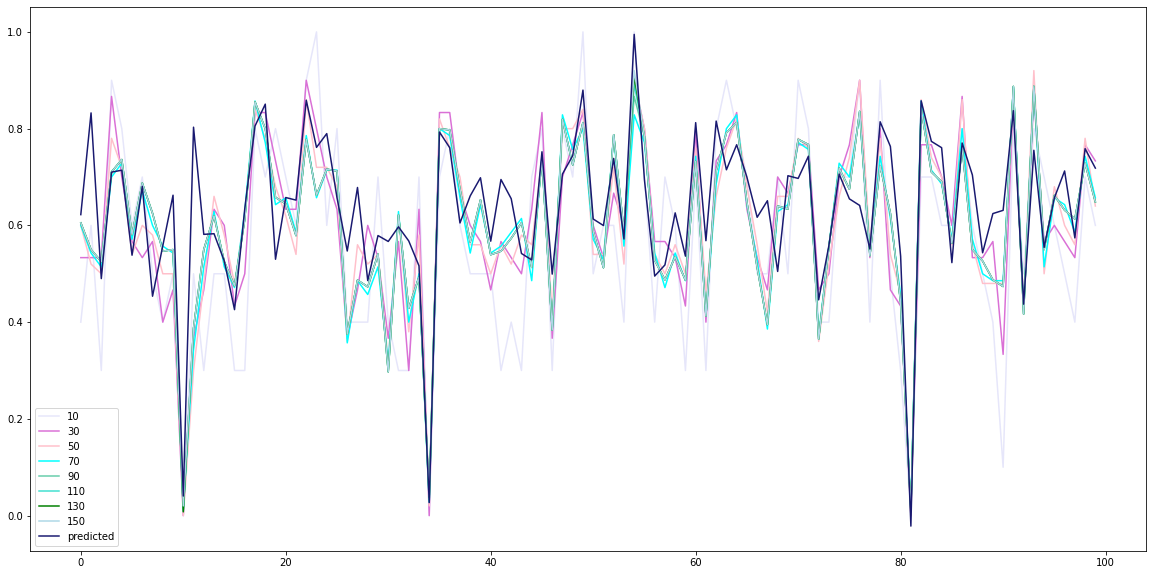

In [ ]:
x=range(len(analysis_top_100['id']))
t = 100
plt.figure(figsize=(20,10))
x = x[:t]
plt.plot(x,analysis_top_100['ann_10'][:t], label= '10', color="lavender")
plt.plot(x,analysis_top_100['ann_30'][:t], label= '30', color='orchid')
plt.plot(x,analysis_top_100['ann_50'][:t], label= '50', color='pink')
plt.plot(x,analysis_top_100['ann_70'][:t], label= '70', color='aqua')
plt.plot(x,analysis_top_100['ann_90'][:t], label= '90', color='mediumaquamarine')
plt.plot(x,analysis_top_100['ann_110'][:t], label= '110', color='turquoise')
plt.plot(x,analysis_top_100['ann_130'][:t], label= '130', color='green')
plt.plot(x,analysis_top_100['ann_150'][:t], label= '150', color='lightblue')

plt.plot(x,analysis_top_100['predicted'][:t], label= 'predicted', color='midnightblue')


# plt.plot(x, Y[:t], label='original', color='midnightblue')
plt.legend()

In [ ]:
analysis_top_100

,id,ann_10,ann_30,ann_50,ann_70,ann_90,ann_110,ann_130,ann_150,sum,predicted,original
srno,,,,,,,,,,,,
0,650904.0,0.4,0.533333,0.60,0.600000,0.605263,0.605263,0.605263,0.605263,4.554386,0.622246,0.605263
1,5410943.0,0.6,0.533333,0.52,0.542857,0.550000,0.550000,0.550000,0.550000,4.396190,0.832540,0.550000
2,5764010.0,0.3,0.533333,0.50,0.514286,0.525000,0.525000,0.525000,0.525000,3.947619,0.489984,0.525000
3,5263240.0,0.9,0.866667,0.78,0.700000,0.710526,0.710526,0.710526,0.710526,6.088772,0.710096,0.710526
4,320268.0,0.8,0.700000,0.72,0.728571,0.736111,0.736111,0.736111,0.736111,5.893016,0.714089,0.736111
...,...,...,...,...,...,...,...,...,...,...,...,...
95,5281381.0,0.6,0.600000,0.68,0.657143,0.661972,0.661972,0.661972,0.661972,5.185030,0.656780,0.661972
96,5820597.0,0.5,0.566667,0.60,0.642857,0.631579,0.631579,0.631579,0.631579,4.835840,0.712505,0.631579
97,5643313.0,0.4,0.533333,0.56,0.585714,0.613333,0.613333,0.613333,0.613333,4.532381,0.574118,0.613333


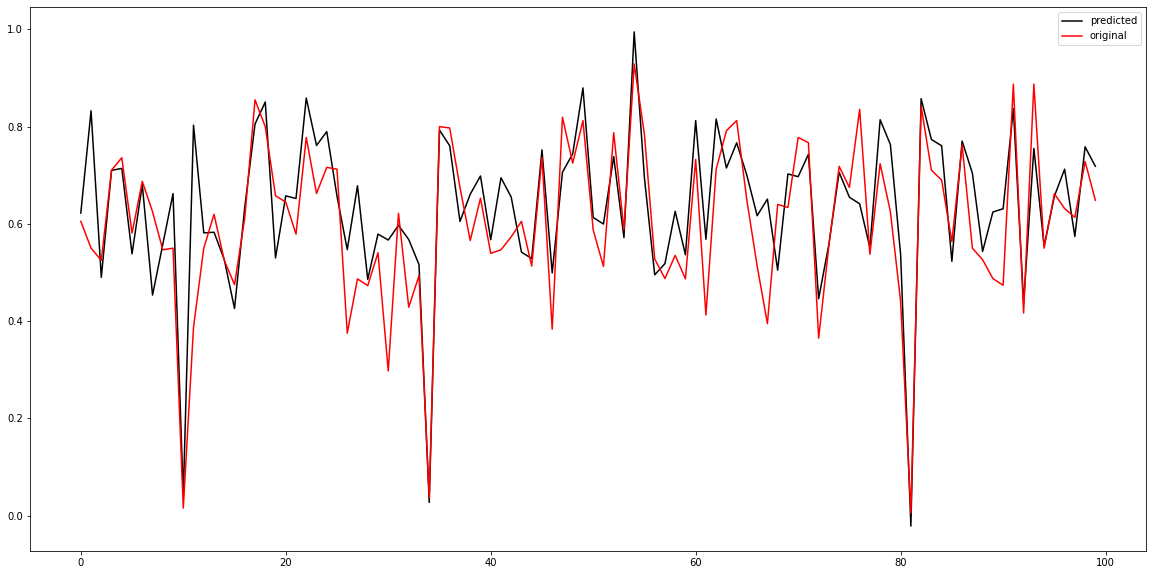

In [ ]:
Y = []
ids = analysis['id']
for i in ids:
  Y.append(float(ambiguous_0[ambiguous_0['id']==i]['toxicity']))

x=range(len(analysis_top_100['id']))
t = 100
plt.figure(figsize=(20,10))
x = x[:t]

plt.plot(x,analysis_top_100['predicted'][:t], label= 'predicted', color='black')


plt.plot(x, Y[:t], label='original', color='red')
plt.legend()

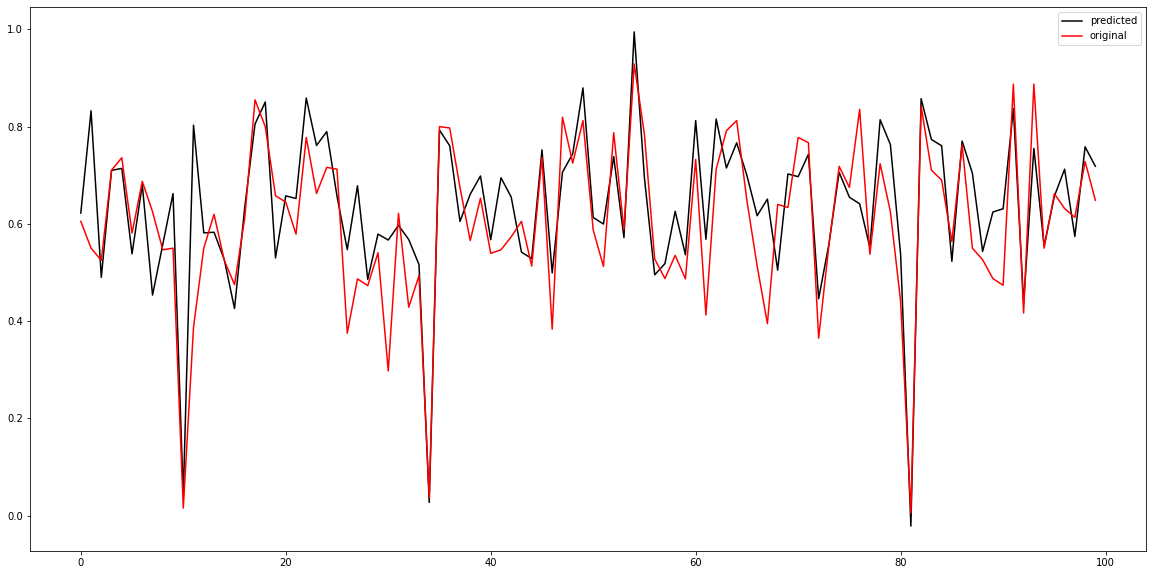

In [ ]:
x=range(len(analysis_top_100['id']))
t = 100
plt.figure(figsize=(20,10))
x = x[:t]

plt.plot(x,analysis_top_100['predicted'][:t], label= 'predicted', color='black')


plt.plot(x, Y[:t], label='original', color='red')
plt.legend()

In [ ]:



Y = []
ids = analysis['id']
for i in ids:
  Y.append(float(ambiguous_0[ambiguous_0['id']==i]['toxicity']))

KeyError: ignored

In [ ]:
rms = {'ann_10':0,'ann_30':0,'ann_50':0,'ann_70':0,'ann_90':0,'ann_110':0,'ann_130':0,'ann_150':0}
for i in analysis_top_100.index:
  for j in rms.keys():
    rms[j]+= (analysis_top_100[j][i] - analysis_top_100['predicted'][i])**2

for j in rms.keys():
  rms[j] = math.sqrt(rms[j]/100)
rms

{'ann_10': 0.16699041316951307,
 'ann_30': 0.11843014928392842,
 'ann_50': 0.10894159667879241,
 'ann_70': 0.10258307240055213,
 'ann_90': 0.10010693677150606,
 'ann_110': 0.0998230425076553,
 'ann_130': 0.09966916721608762,
 'ann_150': 0.099535089774046}

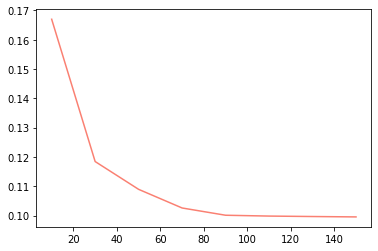

In [ ]:
plt.plot([10,30,50,70,90,110,130,150],list(rms.values()),color = "salmon")

In [ ]:
rms = {'ann_10':0,'ann_30':0,'ann_50':0,'ann_70':0,'ann_90':0,'ann_110':0,'ann_130':0,'ann_150':0}
for i in analysis_top_100.index:
  for j in rms.keys():
    rms[j]+= (analysis_top_100[j][i] - analysis_top_100['original'][i])**2

for j in rms.keys():
  rms[j] = math.sqrt(rms[j]/100)
rms

{'ann_10': 0.13417478778028408,
 'ann_30': 0.06860492324219998,
 'ann_50': 0.04184109723984064,
 'ann_70': 0.018450602349010053,
 'ann_90': 0.00628549842552797,
 'ann_110': 0.0039955628851112215,
 'ann_130': 0.0022870383499742656,
 'ann_150': 0.0010698223303557948}

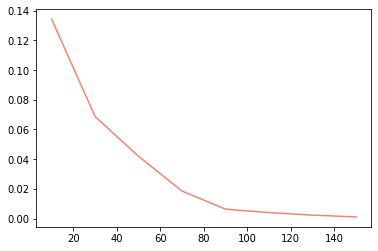

In [ ]:
plt.plot([10,30,50,70,90,110,130,150],list(rms.values()),color = "salmon")